In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [12]:
g = torch.Generator().manual_seed(2147483647)

In [13]:
words = open('names.txt', 'r').read().splitlines()

In [14]:
chars = ['.'] + sorted(list(set(''.join(words))))
encode = lambda c: chars.index(c)
decode = lambda i: chars[i]

In [15]:
block_size = 3
vocab_size = len(chars)

In [16]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = encode(c)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [17]:
def cmp(s, dt, t):
    exact = torch.all(dt == t.grad).item()
    approx = torch.allclose(dt, t.grad)
    max_diff = (torch.abs(dt - t.grad).abs().max().item())
    print(f'{s:15s} exact: {str(exact):5s} approx: {str(approx):5s} max_diff: {max_diff}')


In [18]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass. Because when everything is zero the
# expression of gradient is simplified.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [19]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (n,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

print(Xb.shape, Yb.shape)

torch.Size([32, 3]) torch.Size([32])


In [83]:
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# zero center the batch
bndiff = hprebn - bnmeani
# variance is the sum of the squared differences of examples in the batch from the mean, divided by n-1 (Bessel's correction, divide by n-1 instead of n to improve the estimate of the population variance)
bndiff2 = bndiff**2
bnvar = 1/(n-1) * bndiff2.sum(dim=0, keepdim=True)
# standard deviation is the square root of the variance
# get the inverse of the standard deviation summed with a small constant to avoid division by zero
bnvar_inv = (bnvar + 1e-5)**-0.5
# scale the centered batch by the inverse of the standard deviation
bnraw = bndiff * bnvar_inv
# apply learned gain and bias to the scaled batch
hpreact = bngain * bnraw + bnbias
# apply the tanh activation function
h = torch.tanh(hpreact)
# calculate the logits for the output layer
logits = h @ W2 + b2
# for numerical stability, subtract the maximum logit value in each row
logit_maxes = logits.max(dim=1, keepdim=True).values
norm_logits = logits - logit_maxes # for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean() # we first index by the barch index and then for that particular batch row we take the probability of the character oobserved in the dataset = F.one_hot(Yb, vocab_size) * -1.0/n # n * vocab_size
for p in parameters:
    p.grad = None

for t in reversed([emb, embcat,hprebn, bnmeani, bndiff, bndiff2, bnvar, bnvar_inv, bnraw, hpreact, h, logits, logit_maxes, norm_logits, counts, counts_sum, counts_sum_inv, probs, logprobs]):
    t.retain_grad()

loss.backward()

loss


tensor(2.1205, grad_fn=<NegBackward0>)

In [84]:
dlogprobs = F.one_hot(Yb, vocab_size) * -1.0/n                                  # n * vocab_size
dprobs = dlogprobs * (1.0/probs)                                                # n * vocab_size
dcounts = dprobs * counts_sum_inv                                               # n * vocab_size
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True)                        # n * 1
dcounts_sum = dcounts_sum_inv * -1 * (counts_sum ** -2)                         # n * 1
dcounts += torch.ones_like(counts) * dcounts_sum                                # n * vocab_size
dnorm_logits = dcounts * counts                                                 # n * vocab_size
dlogits = dnorm_logits.clone()                                                  # n * vocab_size    
dlogit_maxes = - dnorm_logits.sum(1, keepdim=True)                              # n * 1
dlogits  += dlogit_maxes * F.one_hot(logits.max(dim=1).indices, vocab_size)     # n * vocab_size
dh = dlogits @ W2.T                                                             # n * n_hidden
dW2 = h.T @ dlogits                                                             # n_hidden * vocab_size
db2 = dlogits.sum(0)                                                            # vocab_size
dhpreact = (1.0 - h**2) * dh                                                    # n * n_hidden
dbngain = (dhpreact * bnraw).sum(0, keepdim=True)                               # 1 * n_hidden
dbnraw = dhpreact * bngain                                                      # n * n_hidden
dbnbias = dhpreact.sum(0, keepdim=True)                                         # 1 * n_hidden           
dbndiff = dbnraw * bnvar_inv                                                    # n * n_hidden
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)                             # 1 * n_hidden
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv                               # 1 * n_hidden
dbndiff2 = torch.ones_like(bndiff2) * (1.0/(n-1)) * dbnvar                      # n * n_hidden
dbndiff += dbndiff2 * 2 * bndiff                                                # n * n_hidden
dhprebn = dbndiff.clone()                                                       # n * n_hidden                             
dbnmeani = (-dbndiff).sum(0)                                                    # 1 * n_hidden
dhprebn += (1/n) * torch.ones_like(hprebn) * dbnmeani                           # n * n_hidden
dembcat = dhprebn @ W1.T                                                        # n * (n_embd * block_size)
dW1 = embcat.T @ dhprebn                                                        # (n_embd * block_size) * n_hidden
db1 = dhprebn.sum(0)                                                            # n_hidden
demb = dembcat.view(emb.shape)                                                  # n * (block_size * n_embd)

X_flatten = Xb.view(-1) 
demb_flatten = demb.view(-1, n_embd)
dC = torch.zeros_like(C)
dC.index_add_(0, X_flatten, demb_flatten)                                       # vocab_size * n_embd

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)
cmp('dbnvar', dbnvar, bnvar)
cmp('dbndiff2', dbndiff2, bndiff2)
cmp('dbndiff', dbndiff, bndiff)
cmp('dbnmeani', dbnmeani, bnmeani)
cmp('dhprebn', dhprebn, hprebn)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)
cmp('demb', demb, emb)
cmp('C', dC, C)

logprobs        exact: True  approx: True  max_diff: 0.0
probs           exact: True  approx: True  max_diff: 0.0
counts_sum_inv  exact: True  approx: True  max_diff: 0.0
counts_sum      exact: True  approx: True  max_diff: 0.0
counts          exact: True  approx: True  max_diff: 0.0
norm_logits     exact: True  approx: True  max_diff: 0.0
logit_maxes     exact: True  approx: True  max_diff: 0.0
logits          exact: True  approx: True  max_diff: 0.0
h               exact: True  approx: True  max_diff: 0.0
W2              exact: True  approx: True  max_diff: 0.0
b2              exact: True  approx: True  max_diff: 0.0
hpreact         exact: True  approx: True  max_diff: 0.0
bngain          exact: True  approx: True  max_diff: 0.0
bnraw           exact: True  approx: True  max_diff: 0.0
dbnbias         exact: True  approx: True  max_diff: 0.0
dbnvar_inv      exact: True  approx: True  max_diff: 0.0
dbnvar          exact: True  approx: True  max_diff: 0.0
dbndiff2        exact: True  ap

# Batch Normalization Derivative

Here are two images illustrating the derivative of the batch normalization layer:

![Batch Normalization Derivative 1](./images/bn_derivative1.jpeg)

![Batch Normalization Derivative 2](./images/bn_derivative2.jpeg)


In [85]:
# manual baclprop thorugh the batchnorm layer: dL/dhprebn
a = (bngain * (bnvar + 1e-05) **-0.5) / n
b = n * hpreact.grad
c = hpreact.grad.sum(dim=0, keepdim=True)
d = (bnraw * hpreact.grad).sum(dim=0, keepdim=True)
e = (n/(n-1))*bnraw*(bnraw * hpreact.grad).sum(dim=0, keepdim=True)
y = a * (b - c - e)
y = (bngain * (bnvar + 1e-05) **-0.5) / n * (n * hpreact.grad - hpreact.grad.sum(dim=0, keepdim=True) - (n/(n-1))*bnraw*(bnraw * hpreact.grad).sum(dim=0, keepdim=True))

cmp('y', y, hprebn)

y               exact: False approx: True  max_diff: 1.862645149230957e-09


In [87]:
loss_fast = F.cross_entropy(logits, Yb)
dlogits_fast = (F.softmax(logits, 1) - F.one_hot(Yb, vocab_size)) / n
cmp('dlogits_fast', dlogits_fast, logits)

dlogits_fast    exact: False approx: True  max_diff: 6.05359673500061e-09


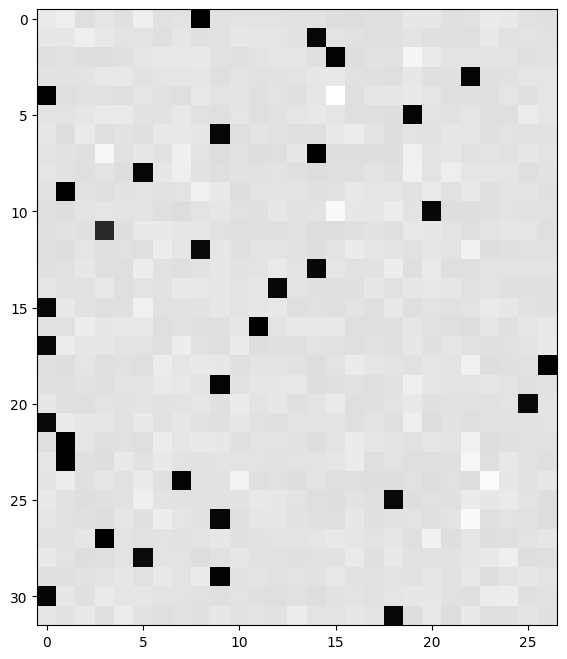

In [106]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [103]:
F.softmax(logits, 1)[0]

tensor([0.0670, 0.0856, 0.0172, 0.0502, 0.0199, 0.0873, 0.0250, 0.0385, 0.0197,
        0.0304, 0.0359, 0.0358, 0.0356, 0.0280, 0.0321, 0.0135, 0.0096, 0.0185,
        0.0158, 0.0548, 0.0529, 0.0218, 0.0248, 0.0718, 0.0613, 0.0252, 0.0217],
       grad_fn=<SelectBackward0>)

In [105]:
x = dlogits[0] * n # times n to undo the mean
x, x.sum()

(tensor([ 0.0670,  0.0856,  0.0172,  0.0502,  0.0199,  0.0873,  0.0250,  0.0385,
         -0.9803,  0.0304,  0.0359,  0.0358,  0.0356,  0.0280,  0.0321,  0.0135,
          0.0096,  0.0185,  0.0158,  0.0548,  0.0529,  0.0218,  0.0248,  0.0718,
          0.0613,  0.0252,  0.0217], grad_fn=<MulBackward0>),
 tensor(-7.4506e-09, grad_fn=<SumBackward0>))

We want to increase the probability of the the right character. Increasing the probability of the righ character means decreaing the counts of the incorrect characters and increasing the counts of the right character. So we will add to the logit of the correct character (-(-0.9803) -> 0.9803) and we will subtract from the logits of the incorrect characters. And the magnitude of the force of the pull upwards (for the correct character) and the force of the pull downwards will be the same (the sum above is zero). So we are pulling and pushing and the amount of the force that we apply is proportional to the probabilities that came out in the forward pass. So if one character was predicted as likely but was actually not, it will get updated more than one that was incorrect but also had low probability.

# Putting it all together

In [176]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass. Because when everything is zero the
# expression of gradient is simplified.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

max_steps = 200000
eval_interval = 10000
batch_size = 32
n = batch_size
lossi = []

with torch.no_grad():
  for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (n,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # -------------------------- FORWARD PASS -------------------------- #
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hprebn = embcat @ W1 + b1

    # -------------------------- BATCHNORM LAYER ----------------------- #
    bnmeani = 1/n*hprebn.sum(0, keepdim=True)
    bndiff = hprebn - bnmeani
    bndiff2 = bndiff**2
    bnvar = 1/(n-1) * bndiff2.sum(dim=0, keepdim=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = bndiff * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------- ACTIVATION FUNCTION ------------------- #
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    # -------------------------- LOSS FUNCTION ------------------------- #
    loss = F.cross_entropy(logits, Yb)

    # -------------------------- BACKWARD PASS ------------------------- #
    dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
    dlogits = (F.softmax(logits, 1) - F.one_hot(Yb, vocab_size)) / n
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    dhpreact = (1.0 - h**2) * dh
    dbnbias = dhpreact.sum(0, keepdim=True)
    dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
    dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(dim=0, keepdim=True) - (n/(n-1))*bnraw*(bnraw * dhpreact).sum(dim=0, keepdim=True))
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    demb = dembcat.view(emb.shape)

    X_flatten = Xb.view(-1)
    demb_flatten = demb.view(-1, n_embd)
    dC = torch.zeros_like(C)
    dC.index_add_(0, X_flatten, demb_flatten)

    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

    # -------------------------- UPDATE PARAMETERS ----------------------- #
    lr = 0.1 if i < max_steps * 0.5 else 0.01

    for p, d in zip(parameters, grads):
      p.data -= lr * d

    if i % eval_interval == 0 or i == max_steps - 1:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
      lossi.append(loss.item())


      0/ 200000: 3.3413
  10000/ 200000: 2.4379
  20000/ 200000: 2.1176
  30000/ 200000: 2.3711
  40000/ 200000: 2.2701
  50000/ 200000: 2.2300
  60000/ 200000: 2.2726
  70000/ 200000: 2.5170
  80000/ 200000: 2.1190
  90000/ 200000: 2.3738
 100000/ 200000: 2.0856
 110000/ 200000: 1.8341
 120000/ 200000: 1.9820
 130000/ 200000: 2.5408
 140000/ 200000: 1.8672
 150000/ 200000: 2.1628
 160000/ 200000: 2.0586
 170000/ 200000: 2.2303
 180000/ 200000: 1.9925
 190000/ 200000: 2.0217
 199999/ 200000: 2.0544


In [173]:
with torch.no_grad():
    # pass the entire training set thorugh the network
    # measure the mean and the standard deviation of hpreact for the entire training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnvar = hpreact.var(dim=0, keepdim=True, unbiased=True)


In [175]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = x @ W1 + b1
  hpreact_centered = hpreact - bnmean
  hpreact_normalized = bngain * (hpreact_centered * (bnvar + 1e-5)**-0.5) + bnbias
  h = torch.tanh(hpreact_normalized)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.1457653045654297
val 2.163302183151245
test 2.1645994186401367


In [178]:
for i in range(20):
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = x @ W1 + b1
        hpreact_centered = hpreact - bnmean
        hpreact_normalized = bngain * (hpreact_centered * (bnvar + 1e-5)**-0.5) + bnbias
        h = torch.tanh(hpreact_normalized)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(decode(ix))
        if ix == 0:
            break
    print(''.join(out))


fini.
sam.
kayanni.
jarjanurryah.
emmurhan.
asme.
prehrunte.
ron.
lenselvelli.
prashs.
savarebrirynnnlee.
phir.
dresh.
dinashutrevyn.
mehnennie.
naigertonnveen.
jacharlinna.
laniniqunne.
jayve.
nhyndrnnyth.
